In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import pyloudnorm as pyln

import cv2 as cv
import librosa
import IPython.display as ipd
import librosa.display as lid
import scipy.signal as signal

from PIL import Image

from tqdm import tqdm
from typing import List, Tuple, Dict

In [2]:
DATA_PATH: str = "birdclef-2025"

In [3]:
train_df = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))
train_df["filepath"] = DATA_PATH + "/train_audio/" + train_df["filename"]

train_df.head()

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license,filepath
0,1139490,[''],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0,birdclef-2025/train_audio/1139490/CSA36385.ogg
1,1139490,[''],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0,birdclef-2025/train_audio/1139490/CSA36389.ogg
2,1192948,[''],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,birdclef-2025/train_audio/1192948/CSA36358.ogg
3,1192948,[''],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,birdclef-2025/train_audio/1192948/CSA36366.ogg
4,1192948,[''],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,birdclef-2025/train_audio/1192948/CSA36373.ogg


In [4]:
class CFG:
    seed: int = 42
    
    img_size: Tuple[int, int] = [128, 384]
    batch_size: int = 64
    
    # Audio duration, sample rate, and length
    duration: int = 15 # second
    sample_rate: int = 32000
    audio_len: int = duration * sample_rate
    
    # STFT parameters
    nfft: int = 1024
    window: int = 1024
    hop_length: int = audio_len // (img_size[1] - 1)
    fmin: int = 20
    fmax: int = 16000
    n_mels: int = 128
    
    # Number of epochs, model name
    epochs: int = 10
    preset: str = 'efficientnetv2_b2_imagenet'
    
    # Data augmentation parameters
    augment=True

    # Class Labels for BirdCLEF 25
    train_path: str = os.path.join(DATA_PATH, "train_audio")
    class_names: List[str] = sorted(os.listdir(train_path))
    num_classes: int = len(class_names)
    class_labels: List[int] = list(range(num_classes))
    label2name: Dict[int, str] = dict(zip(class_labels, class_names))
    name2label: Dict[str, int] = {v:k for k,v in label2name.items()}

In [5]:
cmap = matplotlib.cm.get_cmap('coolwarm')

def bandpass_filter(y, sr, lowcut=500, highcut=10000, order=8):
    sos = signal.butter(order, [lowcut, highcut], btype='band', fs=sr, output='sos')
    filtered = signal.sosfilt(sos, y)
    return filtered


def load_audio(filepath: str, sr: int | None = None) -> Tuple[np.ndarray, int]:
    audio, sr = librosa.load(filepath, sr=sr)
    return audio, sr


def get_spectrogram(audio: np.ndarray) -> np.ndarray:
    spec = librosa.feature.melspectrogram(y=audio, 
                                   sr=CFG.sample_rate, 
                                   n_mels=CFG.n_mels,
                                   n_fft=CFG.nfft,
                                   hop_length=CFG.hop_length,
                                   win_length=CFG.window,
                                   fmax=CFG.fmax,
                                   fmin=CFG.fmin,
                                   )
    spec = librosa.power_to_db(spec, ref=1.0)
    min_ = spec.min()
    max_ = spec.max()
    if max_ != min_:
        spec = (spec - min_)/(max_ - min_)
    return spec


def display_audio(row: pd.DataFrame, LUFS: float = 1, filtering: bool = False, seconds: int = -1) -> None:
    # Caption for viz
    caption = f'Id: {row["filename"]} | Name: {row["common_name"]} | Sci.Name: {row["scientific_name"]} | Rating: {row["rating"]}'
    # Read audio file
    audio, sr = load_audio(row["filepath"])
    if seconds != -1:
        audio = audio[:seconds * CFG.sample_rate]
    
    if LUFS != 1:
        meter = pyln.Meter(sr)
        loudness = meter.integrated_loudness(audio)
        audio = pyln.normalize.loudness(audio, loudness, LUFS)

    if filtering:
        audio = bandpass_filter(audio, sr)
    # Keep fixed length audio
    # audio = audio[:CFG.audio_len]
    # Spectrogram from audio
    spec = get_spectrogram(audio)
    # Display audio
    print(sr)
    print(len(audio), audio.shape)
    print("# Audio:")
    display(ipd.Audio(audio, rate=CFG.sample_rate))
    print('# Visualization:')
    
    # Calculate the time values based on audio length and sample rate
    duration = len(audio) / CFG.sample_rate
    time = np.linspace(0, duration, len(audio))
    
    # Create figure with subplots
    fig, ax = plt.subplots(2, 1, figsize=(12, 2*3), sharex=False, tight_layout=True)
    fig.suptitle(caption)
    
    # Plot waveplot with time axis
    ax[0].plot(time, audio, color=cmap(0.1))
    ax[0].set_ylabel('Amplitude')
    # ax[0].set_xlabel('Time (s)')
    ax[0].set_xlim(0, duration)

    # Plot spectrogram
    lid.specshow(spec, 
                 sr=CFG.sample_rate, 
                 hop_length=CFG.hop_length,
                 win_length=CFG.window,
                 n_fft=CFG.nfft,
                 fmin=CFG.fmin,
                 fmax=CFG.fmax,
                 x_axis='time', 
                 y_axis='mel',
                 cmap='coolwarm',
                 ax=ax[1])
    ax[1].set_xlabel('Time (s)')
    ax[1].set_xlim(0, duration)
    
    fig.show()

C:\Users\artur\AppData\Local\Temp\ipykernel_3532\3226807668.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap('coolwarm')


In [6]:
def mirror_pad_audio(audio, target_len):
    if len(audio) >= target_len:
        return audio[:target_len]

    pad_len = target_len - len(audio)
    pad_left = pad_len // 2
    pad_right = pad_len - pad_left

    audio_padded = np.pad(audio, (pad_left, pad_right), mode='reflect')
    return audio_padded

In [7]:
generate_images = False

labels: List[int | str] = []
image_path: List[str] = []
images_path = os.path.join(DATA_PATH, "train_images")
os.makedirs(images_path, exist_ok=True)

for path, label, filename in tqdm(zip(train_df["filepath"], train_df["primary_label"], train_df["filename"]), total=len(train_df)):
    img_path = os.path.join(images_path, filename.replace(".ogg", ".png"))
    
    if generate_images:
        audio, sr = load_audio(path)
        audio = mirror_pad_audio(audio, 5 * CFG.audio_len)
        spec = get_spectrogram(audio)
        spec = (spec * 255).astype(np.int16)
    
        os.makedirs(os.path.dirname(img_path), exist_ok=True)
        cv.imwrite(img_path, spec)
    
    labels.append(label)
    image_path.append(img_path)
    
labels = [CFG.name2label[label] for label in labels]

  0%|          | 0/28564 [00:00<?, ?it/s]

100%|██████████| 28564/28564 [00:00<00:00, 344415.89it/s]


[[  0   0   0 ... 172 158 173]
 [  0   0   0 ... 185 155 169]
 [  0   0   0 ... 197 142 160]
 ...
 [  0   0   0 ...  73  55  55]
 [  0   0   0 ...  52  43  40]
 [  0   0   0 ...   0   0   0]]


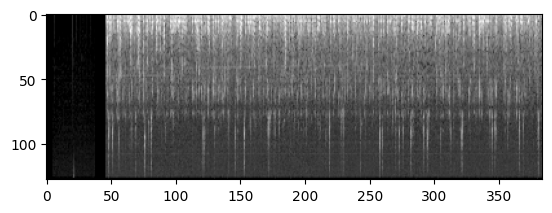

In [8]:
img = cv.imread(image_path[0])
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img = cv.resize(img, (CFG.img_size[1], CFG.img_size[0]), interpolation=cv.INTER_LINEAR)
print(img)
imshow(img, cmap='gray')

# Training

In [9]:
import torch

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models

In [10]:
class SpectogramDataset(Dataset):
    def __init__(self, image_paths: List[str], labels: List[int], 
                 transform: transforms.Compose | None = None):
        super().__init__()
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index: int):
        image = cv.imread(self.image_paths[index])
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        label = self.labels[index]
        
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        return image, label

In [11]:
class EfficientNet(nn.Module):
    def __init__(self, num_classes: int = 1, depth: int = 3, infer_mode: bool = False, grayscale: bool = False):
        super().__init__()
        depth_models = {
            0: models.efficientnet_b0,
            1: models.efficientnet_b1,
            2: models.efficientnet_b2,
            3: models.efficientnet_b3,
            4: models.efficientnet_b4,
            5: models.efficientnet_b5,
            6: models.efficientnet_b6,
            7: models.efficientnet_b7,
        }

        self.infer_mode = infer_mode
        self.base_model = depth_models[depth](pretrained=True)

        if grayscale:
            original_conv: nn.Conv2d = self.base_model.features[0][0]
            self.base_model.features[0][0] = nn.Conv2d(
                in_channels=1,
                out_channels=original_conv.out_channels,
                kernel_size=original_conv.kernel_size,
                stride=original_conv.stride,
                padding=original_conv.padding,
                bias=original_conv.bias
            )

        head_in_features = self.base_model.classifier[1].in_features
        self.base_model.classifier = nn.Sequential(
            nn.Linear(head_in_features, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(p=0.3),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.base_model(x)
        if self.infer_mode:
            x = 1 if torch.sigmoid(x) > 0.5 else 0
        return x


In [12]:
from sklearn.metrics import roc_auc_score

def train_step(train_loader: DataLoader, model: nn.Module, criterion: nn.Module, optimizer: torch.optim, epoch: int, total_epochs: int, device: str = "cuda") -> float:
    model.train()
    step_loss: float = 0.0

    for batch, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{total_epochs}"):
        labels = labels.view(-1, 1).float()
        batch, labels = batch.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()
        step_loss += loss.item()
    return step_loss / len(train_loader)    


def evaluate_model(test_loader: DataLoader, model: nn.Module, criterion: nn.Module | None = None, device: str = "cuda") -> Tuple[float, float]:
    model.to(device)
    model.eval()
    test_loss: float = 0.0

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch, labels in tqdm(test_loader):
            batch, labels = batch.to(device), labels.to(device)

            outputs = model(batch)
            probs = torch.sigmoid(outputs)

            if criterion is not None:
                loss = criterion(outputs, labels.float())
                test_loss += loss.item()

            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)

    try:
        roc_auc = roc_auc_score(all_labels, all_probs, average="macro")
    except ValueError:
        roc_auc = float("nan")

    return test_loss / len(test_loader), roc_auc


def train_model(model: nn.Module, 
                train_loader: DataLoader, 
                val_loader: DataLoader,
                criterion: nn.Module,
                optimizer: torch.optim,
                num_epochs: int,
                model_path: str,
                validation_step: int = 5,
                device: str = "cuda") -> float:
    best_rocauc = 0.0

    for epoch in range(num_epochs):
        train_loss = train_step(train_loader, model, criterion, optimizer, epoch, num_epochs, device)
        print(f"Train loss: {train_loss}")
        if (epoch + 1) % validation_step == 0:
            val_loss, rocauc = evaluate_model(val_loader, model, criterion, device)
            print(f"Val loss: {val_loss}, F1-micro: {rocauc:.3f}")
            if rocauc >= best_rocauc:
                best_rocauc = rocauc
                torch.save(model.state_dict(), model_path)
    return best_rocauc

In [13]:
print(labels == sorted(labels))

True


In [14]:
curr_label = labels[0]
train_path = []
train_labels = []
val_path = []
val_labels = []

first_idx = 0
for i in tqdm(range(len(labels))):
    if labels[i] != curr_label:
        idxces = np.arange(first_idx, i)
        np.random.shuffle(idxces)
        
        val_num = int(len(idxces) * 0.2)
        if len(idxces) < 5:
            val_num = 1
        train_num = len(idxces) - val_num
        for j in range(train_num):
            idx = idxces[j]
            train_path.append(image_path[idx])
            train_labels.append(labels[idx])
        
        for j in range(train_num, train_num + val_num):
            idx = idxces[j]
            val_path.append(image_path[idx])
            val_labels.append(labels[idx])
        first_idx = i
        curr_label = labels[i]

100%|██████████| 28564/28564 [00:00<00:00, 1431734.36it/s]

In [15]:
IMAGE_SIZE = (260, 260)

In [16]:
class TimeMasking(torch.nn.Module):
    def __init__(self, mask_param: float = 0.12):
        super().__init__()
        self.mask_param = mask_param

    def forward(self, x):
        _, _, w = x.shape
        mask_width = int(w * np.random.uniform(0.06, self.mask_param))
        t0 = np.random.randint(0, max(1, w - mask_width))
        x[:, :, t0:t0 + mask_width] = 0
        return x


class FrequencyMasking(torch.nn.Module):
    def __init__(self, mask_param: float = 0.1):
        super().__init__()
        self.mask_param = mask_param

    def forward(self, x):
        _, h, _ = x.shape
        mask_height = int(h * np.random.uniform(0.06, self.mask_param))
        f0 = np.random.randint(0, max(1, h - mask_height))
        x[:, f0:f0 + mask_height, :] = 0
        return x


transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(IMAGE_SIZE),
    TimeMasking(mask_param=0.12),
    FrequencyMasking(mask_param=0.1)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(IMAGE_SIZE)
])

In [17]:
train_dataset = SpectogramDataset(train_path, train_labels, transform=transform_train)
val_dataset = SpectogramDataset(train_path, train_labels, transform=transform_test)

In [18]:
def plot_batch(dataset, row=3, col=3):
    """Plot one batch data"""
    plt.figure(figsize=(col*5, row*3))
    for idx in range(row*col):
        ax = plt.subplot(row, col, idx+1)
        specs = dataset[idx][0].numpy()
        specs = np.transpose(specs, (1, 2, 0))[:, :, 0]
        lid.specshow(np.array(specs), 
                     n_fft=CFG.nfft, 
                     hop_length=CFG.hop_length, 
                     sr=CFG.sample_rate,
                     x_axis='time',
                     y_axis='mel',
                     cmap='coolwarm')
    plt.tight_layout()
    plt.show()

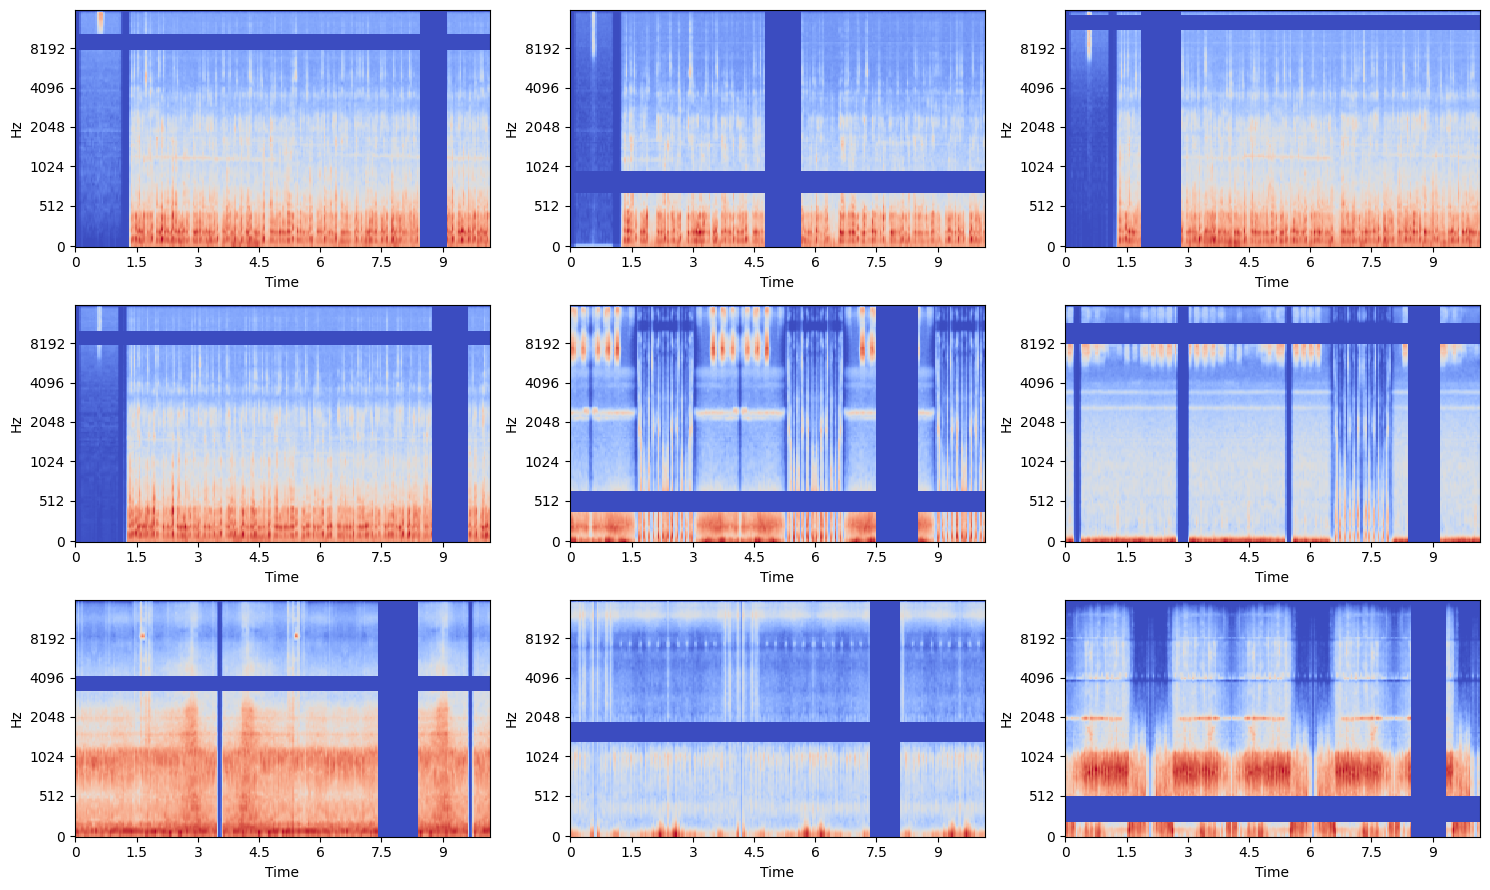

In [19]:
plot_batch(train_dataset)

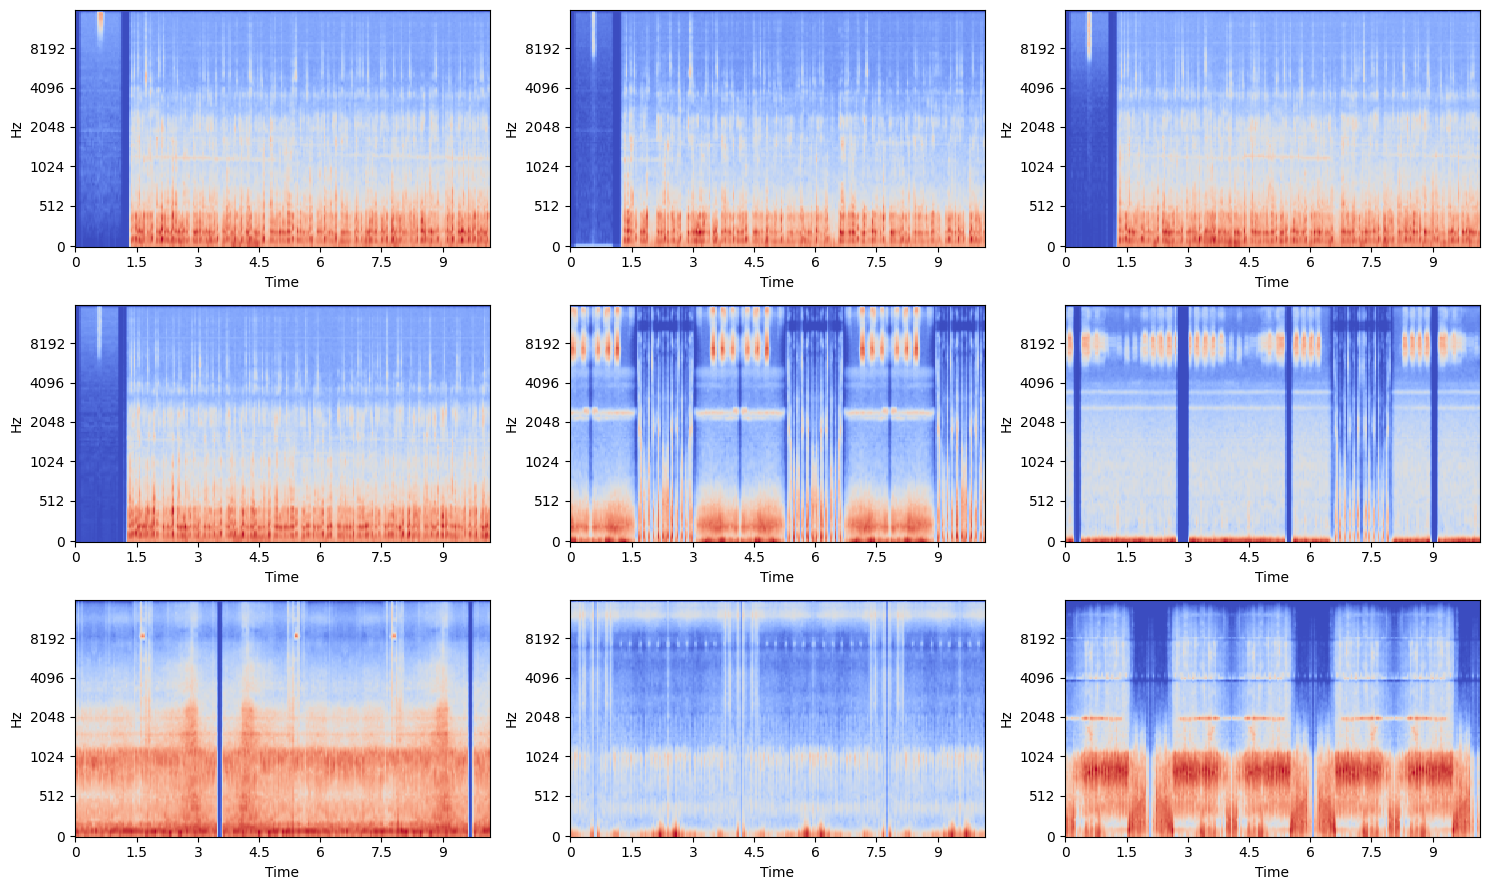

In [20]:
plot_batch(val_dataset)

In [21]:
BATCH_SIZE = 8
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

train_loader = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True,
                          num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1)

In [22]:
EPOCHS = 10
LEARNING_RATE = 3e-3
MODEL_PATH = "efficientnetv2_b2.pth"

efficientnet = EfficientNet(depth=2).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=efficientnet.parameters(), lr=LEARNING_RATE)

e:\UCU Third Year\Term 2\Audio Processing\Audio_Processing_Labs\Lab3\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\UCU Third Year\Term 2\Audio Processing\Audio_Processing_Labs\Lab3\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
best_roc_auc = train_model(model=efficientnet, 
                      train_loader=train_loader, 
                      val_loader=val_loader,
                      criterion=criterion,
                      optimizer=optimizer,
                      num_epochs=EPOCHS,
                      model_path=MODEL_PATH,
                      device=DEVICE)